# Create streamplots from the LES data 

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import loadmat
import os

figdir = Path(os.getcwd()).parent / "fig"
figdir.mkdir(exist_ok=True, parents=True)

datadir = Path(os.getcwd()) / "LES_data" / "LES_fields.mat"
%load_ext autoreload
%autoreload 2
print(figdir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jaime/Repositories/Unified-Momentum-Model/fig


LES data have been generated from the pseudo-spectral code [PadeOps](https://github.com/Howland-Lab/PadeOps). 

The data here have been exported to a `.mat` file for convenience. Arrays of $\bar{u}$, $\bar{v}$, and $\bar{p}$ are given for $C_T = [-2.0, 1.0, 1.5]$. Additionally, axes at which the exported data are saved are given by variables $x/D$, $y/D$, and $z/D$ for the turbine-normalized streamwise, spanwise, and vertical coordinates, respectively. 

In [13]:
data = loadmat(datadir)

Define the plotting function here: 

In [14]:
def plot(
    ax,
    u,
    v,
    p,
    x,
    y,
    ct,
    alpha_x=1.5,
    alpha_y=0.4,
    lw_max=2.0,
    lw_exp=0.6,
    density=0.9,
    start_points=None,
    cmap="RdBu",
    streamline_color="k",
    turbine_color="tab:gray",
    plot_turbine=True,
):
    """
    Plotting function for streamlines and pressure contours
    """

    extent = [x.min(), x.max(), y.min(), y.max()]

    # streamlines look nicer with some base velocity
    vbar_base = 0.1 * np.mean(np.abs(v))
    s = np.sqrt(v**2 + vbar_base)  # + sl['ubar']**2)
    # set the linewidth based on lateral velocity vbar
    lw = (s**lw_exp).T
    lw = lw / np.max(lw) * lw_max
    xG, yG = np.meshgrid(x, y)
    ymask = (yG > 0).reshape(xG.shape)

    # use a weighting function to mask out background field to white
    weight = np.exp(-yG.T**2 / (2 * alpha_y**2) - xG.T**2 / (2 * alpha_x**2))
    weight /= np.max(weight)
    field = p * weight  # taper color at the edges

    # LAYER 0: base field + tapering
    cmax = np.max(abs(field))
    ax.imshow(
        field.T,
        origin="lower",
        extent=extent,
        cmap=cmap,
        interpolation="bicubic",
        clim=[-cmax, cmax],
        zorder=0,
    )

    # LAYER 1: Mask to white
    # Regardless of the colormap used in the contours, adding an
    # additional mask will help the edges fade to white
    f_mask = np.exp(-yG.T**2 / (4 * alpha_y**2) - xG.T**2 / (4 * alpha_x**2))
    f_mask = 1 - f_mask / np.max(f_mask)  # invert
    ax.imshow(
        np.ones_like(field).T,
        origin="lower",
        extent=extent,
        cmap="binary_r",
        interpolation="bilinear",
        clim=[-1, 1],
        zorder=1,
        alpha=f_mask.T,
    )

    # LAYER 2: Plot turbine line
    if plot_turbine:
        ax.plot(
            [0, 0],
            np.array([-0.5, 0.5]),
            color=turbine_color,
            lw=0.5,
            zorder=2,
            solid_capstyle="round",
        )

    # LAYER 3: Plot streamlines
    if start_points is None:
        start_points = get_start_points(ct, u=u, x=x)
    # plot y>0 streamlines
    _u = np.ma.array(u.T, mask=~ymask)
    _v = np.ma.array(v.T, mask=~ymask)

    if streamline_color is None:
        streamline_color = "k"  # Streamline color

    # plot streamlines, top half, then bottom half
    ret = ax.streamplot(
        xG,
        yG,
        _u,
        _v,
        color=streamline_color,
        arrowstyle="fancy",
        arrowsize=0.7,
        density=density,
        start_points=start_points,
        linewidth=lw,
        zorder=3,
    )
    ret.lines.set_capstyle(
        "round"
    )  # try to fix the disconnected line segments visually

    # plot y < 0
    _u = np.ma.array(u.T, mask=ymask)  # flip the mask
    _v = np.ma.array(v.T, mask=ymask)
    start_points[:, 1] *= -1  # symmetrical but reflected starting points
    ret = ax.streamplot(
        xG,
        yG,
        _u,
        _v,
        color=streamline_color,
        arrowstyle="fancy",
        arrowsize=0.7,
        density=density,
        start_points=start_points,
        linewidth=lw,
        zorder=3,
    )
    ret.lines.set_capstyle(
        "round"
    )  # try to fix the disconnected line segments visually

    # turn the axis off
    plt.axis("off")

    return


def get_start_points(ct, N=3, R=0.5, xval=-2.0, u=None, x=None):
    """Get starting seed locations to produce nice looking streamlines"""
    if ct < -1:
        sp = np.ones((N, 2)) * 2  # start downstream at (2, y)
        sp[:, 1] = np.linspace(R / N, 2 * R, N)
    elif ct < 1.1:
        sp = np.ones((N, 2)) * -2  # start upstream at (-2, y)
        sp[:, 1] = np.linspace(R / N, 2 * R, N)
    else:
        xid = np.argmin(u[:, u.shape[1] // 2], axis=0)  # smallest u along centerline
        xval = x[xid]

        mid = np.ceil(N).astype(int)
        sp = np.ones((N + mid * 2, 2)) * -2  # start upstream
        sp[0:N, 1] = np.linspace(R / N, 2 * R, N)
        # additionally, seed points in the recirculation bubble
        sp[N : N + mid, 0] = xval
        sp[N : N + mid, 1] = np.linspace(R / (2 * N), R, mid)
        # finally, seed points in the wake
        sp[N + mid :, 0] = 2
        sp[N + mid :, 1] = np.linspace(R / (2 * N), 1.5 * R, mid)

    return sp

C_T: -2.0


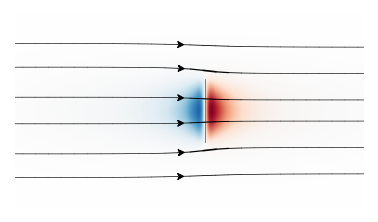

C_T: 1.0


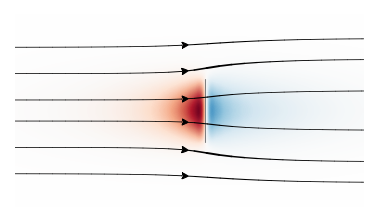

C_T: 1.5


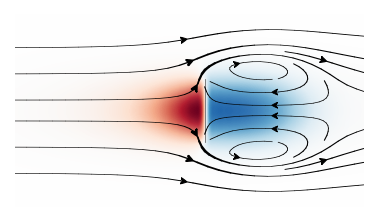

In [15]:
x = data["x"][0]
y = data["y"][0]
cts = data["ct"][0]

for k, ct in enumerate(cts):
    print(f"C_T: {ct:.1f}")
    fig, ax = plt.subplots(figsize=(3, 2), dpi=150)
    plot(
        ax,
        data["u"][k],
        data["v"][k],
        data["p"][k],
        x,
        y,
        ct,
        lw_max=1.3,
        density=0.9,
        lw_exp=0.7,
        cmap="RdBu_r",
    )
    plt.savefig(figdir / f"Figure1_streamline_ct_{ct:.1f}.png", dpi=1200)
    plt.show()
